### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import snscrape.modules.twitter as sntwitter
import matplotlib.pyplot as plt
from matplotlib import style

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

from collections import Counter
import re

### Load the data

In [2]:
df = pd.read_csv('atiku.csv')

In [3]:
save_df = pd.read_csv('atiku.csv')
save_df.head()

,Unnamed: 0,date,user,source,tweet,location,like_count,retweet_count
0,0,2022-11-29 23:25:12+00:00,BUKOLA00459341,Twitter for Android,@pdpnewgen @PDPAwareness @MobilePunch @PulseNi...,"Maryland, USA",0,0
1,1,2022-11-29 23:07:51+00:00,DrCharlesOdogwu,Twitter for iPhone,#AtikuOkowa2023 #AtikuInOndo,Nigeria,0,0
2,2,2022-11-29 23:04:29+00:00,DavidOkooza,Twitter for iPhone,Borno state PDP is doing well.. We will recove...,"Blue Earth, MN",2,4
3,3,2022-11-29 22:57:15+00:00,MikanoLeader,Twitter for Android,Borno state PDP is doing well.. We will recove...,NaN,59,26
4,4,2022-11-29 22:38:23+00:00,Adamujadas,Twitter for Android,Atiku/Okowa is the only best Candidate we have...,NaN,2,0


In [4]:
df = df.iloc[:, 1:]
df.head()

,date,user,source,tweet,location,like_count,retweet_count
0,2022-11-29 23:25:12+00:00,BUKOLA00459341,Twitter for Android,@pdpnewgen @PDPAwareness @MobilePunch @PulseNi...,"Maryland, USA",0,0
1,2022-11-29 23:07:51+00:00,DrCharlesOdogwu,Twitter for iPhone,#AtikuOkowa2023 #AtikuInOndo,Nigeria,0,0
2,2022-11-29 23:04:29+00:00,DavidOkooza,Twitter for iPhone,Borno state PDP is doing well.. We will recove...,"Blue Earth, MN",2,4
3,2022-11-29 22:57:15+00:00,MikanoLeader,Twitter for Android,Borno state PDP is doing well.. We will recove...,NaN,59,26
4,2022-11-29 22:38:23+00:00,Adamujadas,Twitter for Android,Atiku/Okowa is the only best Candidate we have...,NaN,2,0


### Inspect the data

In [5]:
df.shape

(10001, 7)

In [6]:
df.isna().sum()

date                0
user                0
source              0
tweet               0
location         2542
like_count          0
retweet_count       0
dtype: int64

In [7]:
len(df.user.unique())

2040

In [8]:
len(df.source.unique())

18

In [9]:
len(df.location.unique())

580

### Inspect trending hashtags

In [10]:
def hashtag(tweet):
    tags = re.findall(r'#(\w+)', tweet)
    return ' '.join(tags)

In [11]:
df['hashtags'] = df['tweet'].apply(hashtag)
df.head(5)

,date,user,source,tweet,location,like_count,retweet_count,hashtags
0,2022-11-29 23:25:12+00:00,BUKOLA00459341,Twitter for Android,@pdpnewgen @PDPAwareness @MobilePunch @PulseNi...,"Maryland, USA",0,0,AtikuOkowa2023
1,2022-11-29 23:07:51+00:00,DrCharlesOdogwu,Twitter for iPhone,#AtikuOkowa2023 #AtikuInOndo,Nigeria,0,0,AtikuOkowa2023 AtikuInOndo
2,2022-11-29 23:04:29+00:00,DavidOkooza,Twitter for iPhone,Borno state PDP is doing well.. We will recove...,"Blue Earth, MN",2,4,RecoverNigeria
3,2022-11-29 22:57:15+00:00,MikanoLeader,Twitter for Android,Borno state PDP is doing well.. We will recove...,NaN,59,26,RecoverNigeria
4,2022-11-29 22:38:23+00:00,Adamujadas,Twitter for Android,Atiku/Okowa is the only best Candidate we have...,NaN,2,0,AtikuOkowa2023 AtikuOrganizingForAction


In [12]:
hashtags_list = df['hashtags'].tolist()

hashtags = []
for item in hashtags_list:
    item = item.split()
    for i in item:
        hashtags.append(i)

        
counts = Counter(hashtags)
hashtags_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
hashtags_df.columns = ['Hashtags', 'Count']
hashtags_df.sort_values(by='Count', ascending=False, inplace=True)

In [13]:
top_ten = hashtags_df.head(10)
top_ten.head()

,Hashtags,Count
0,AtikuOkowa2023,6811
10,AtikuOkowa,1825
2,RecoverNigeria,1037
29,AtikuAbubakar,509
30,The300TrillionNairaPrivateSectorInvestmentStra...,396


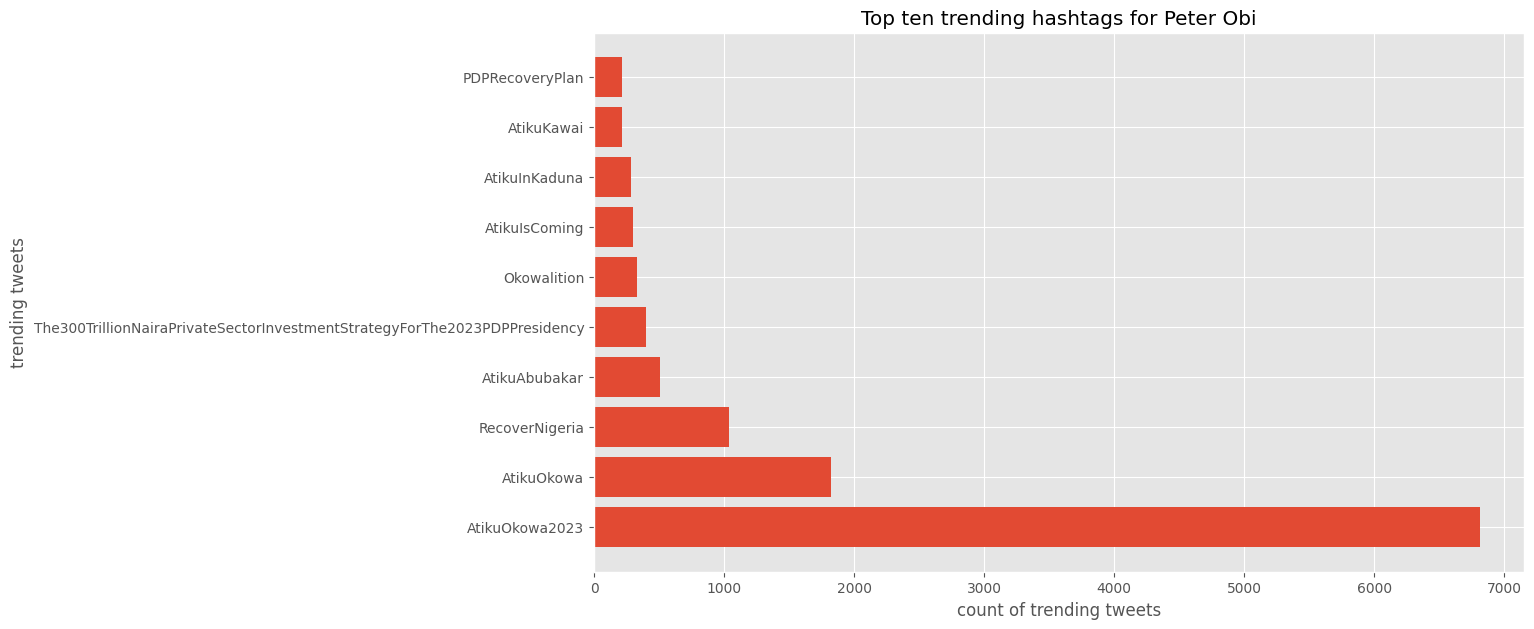

In [14]:
style.use('ggplot')
plt.figure(figsize=(12,7))
plt.barh(top_ten.Hashtags, top_ten.Count)
plt.ylabel('trending tweets')
plt.xlabel('count of trending tweets')
plt.title('Top ten trending hashtags for Peter Obi')
plt.show()

### Data cleaning and preprocessing

In [15]:
def clean_tweet(text):
    text = re.sub(r'#[A-Za-z0-9^\w]+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
#     text = re.sub(r'[^\w]', ' ', text)
    
    return text

In [16]:
def preprocess(text):
    preprocessed_text = []
    for t in text.split():
        if len(t) > 1:
            t = '@user' if t[0] == '@' and t.count('@') == 1 else t
            t = 'http' if t.startswith('http') else t
        preprocessed_text.append(t)
    return ' '.join(preprocessed_text)

In [17]:
df['tweet'] = df['tweet'].apply(preprocess)

for i, j in enumerate(df['tweet']):
    print(i, j, '\n')
    if i > 5:
        break

0 @user @user @user @user @user @user #AtikuOkowa2023 in Ondo-State 

1 #AtikuOkowa2023 #AtikuInOndo 

2 Borno state PDP is doing well.. We will recover Borno come 2023. #RecoverNigeria with AtikuOkowa http 

3 Borno state PDP is doing well.. We will recover Borno come 2023. #RecoverNigeria with AtikuOkowa http 

4 Atiku/Okowa is the only best Candidate we have in Nigeria right now. My voter's card and my family's is for Atiku/Okowa insha Allah. Come 2023 vote Wisely. ONDO ATIKU IS COMING #AtikuOkowa2023 #AtikuOrganizingForAction http 

5 #AtikuOkowa2023 #AtikuInOndo, the Sunshine State. Follow us on all our social media handles for updates. Come…Let’s #RecoverNigeria Together. http 

6 The man behind the #AtikuPlan is ATIKU ABUBAKAR. He never runs without a well-thought-out strategy in mind. He is always well-prepared. #AtikuCan #AtikuOkowa2023 #AtikuOrganizingForAction http 



In [18]:
df['tweet'] = df['tweet'].apply(clean_tweet)

for i, j in enumerate(df['tweet']):
    print(i, j, '\n')
    if i > 5:
        break

0 @user @user @user @user @user @user  in Ondo-State 

1   

2 Borno state PDP is doing well.. We will recover Borno come 2023.  with AtikuOkowa http 

3 Borno state PDP is doing well.. We will recover Borno come 2023.  with AtikuOkowa http 

4 Atiku/Okowa is the only best Candidate we have in Nigeria right now. My voter's card and my family's is for Atiku/Okowa insha Allah. Come 2023 vote Wisely. ONDO ATIKU IS COMING   http 

5  , the Sunshine State. Follow us on all our social media handles for updates. Come…Let’s  Together. http 

6 The man behind the  is ATIKU ABUBAKAR. He never runs without a well-thought-out strategy in mind. He is always well-prepared.    http 



### Tweet labelling using Pre-trained Roberta (Transformer Model)

In [19]:
roberta = 'cardiffnlp/twitter-roberta-base-sentiment'
model = AutoModelForSequenceClassification.from_pretrained(roberta, from_tf=True)
tokenizer = AutoTokenizer.from_pretrained(roberta)

All TF 2.0 model weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use RobertaForSequenceClassification for predictions without further training.


In [20]:
from transformers import pipeline

In [21]:
sentiment_task = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

### Working on full dataset

In [22]:
df.head()

,date,user,source,tweet,location,like_count,retweet_count,hashtags
0,2022-11-29 23:25:12+00:00,BUKOLA00459341,Twitter for Android,@user @user @user @user @user @user in Ondo-S...,"Maryland, USA",0,0,AtikuOkowa2023
1,2022-11-29 23:07:51+00:00,DrCharlesOdogwu,Twitter for iPhone,,Nigeria,0,0,AtikuOkowa2023 AtikuInOndo
2,2022-11-29 23:04:29+00:00,DavidOkooza,Twitter for iPhone,Borno state PDP is doing well.. We will recove...,"Blue Earth, MN",2,4,RecoverNigeria
3,2022-11-29 22:57:15+00:00,MikanoLeader,Twitter for Android,Borno state PDP is doing well.. We will recove...,NaN,59,26,RecoverNigeria
4,2022-11-29 22:38:23+00:00,Adamujadas,Twitter for Android,Atiku/Okowa is the only best Candidate we have...,NaN,2,0,AtikuOkowa2023 AtikuOrganizingForAction


In [23]:
df.shape

(10001, 8)

In [24]:
full_analysis = sentiment_task(df['tweet'].tolist())

In [25]:
full_analysis

[{'label': 'LABEL_1', 'score': 0.8640717267990112},
 {'label': 'LABEL_1', 'score': 0.5058801770210266},
 {'label': 'LABEL_2', 'score': 0.8863380551338196},
 {'label': 'LABEL_2', 'score': 0.8863380551338196},
 {'label': 'LABEL_2', 'score': 0.9243702292442322},
 {'label': 'LABEL_2', 'score': 0.4994148313999176},
 {'label': 'LABEL_2', 'score': 0.64117431640625},
 {'label': 'LABEL_2', 'score': 0.9691594243049622},
 {'label': 'LABEL_1', 'score': 0.45127245783805847},
 {'label': 'LABEL_2', 'score': 0.9554239511489868},
 {'label': 'LABEL_2', 'score': 0.9113257527351379},
 {'label': 'LABEL_1', 'score': 0.8434925079345703},
 {'label': 'LABEL_1', 'score': 0.4871179759502411},
 {'label': 'LABEL_2', 'score': 0.6443921327590942},
 {'label': 'LABEL_2', 'score': 0.4994148313999176},
 {'label': 'LABEL_2', 'score': 0.7980891466140747},
 {'label': 'LABEL_1', 'score': 0.49976348876953125},
 {'label': 'LABEL_1', 'score': 0.6389312148094177},
 {'label': 'LABEL_2', 'score': 0.6732228994369507},
 {'label': '

In [26]:
len(full_analysis)

10001

In [27]:
count = 0
for i in full_analysis:
    df.loc[count, 'sentiment'] = full_analysis[count]['label']
    df.loc[count, 'score'] = full_analysis[count]['score']
    count += 1

In [28]:
df.head()

,date,user,source,tweet,location,like_count,retweet_count,hashtags,sentiment,score
0,2022-11-29 23:25:12+00:00,BUKOLA00459341,Twitter for Android,@user @user @user @user @user @user in Ondo-S...,"Maryland, USA",0,0,AtikuOkowa2023,LABEL_1,0.864072
1,2022-11-29 23:07:51+00:00,DrCharlesOdogwu,Twitter for iPhone,,Nigeria,0,0,AtikuOkowa2023 AtikuInOndo,LABEL_1,0.505880
2,2022-11-29 23:04:29+00:00,DavidOkooza,Twitter for iPhone,Borno state PDP is doing well.. We will recove...,"Blue Earth, MN",2,4,RecoverNigeria,LABEL_2,0.886338
3,2022-11-29 22:57:15+00:00,MikanoLeader,Twitter for Android,Borno state PDP is doing well.. We will recove...,NaN,59,26,RecoverNigeria,LABEL_2,0.886338
4,2022-11-29 22:38:23+00:00,Adamujadas,Twitter for Android,Atiku/Okowa is the only best Candidate we have...,NaN,2,0,AtikuOkowa2023 AtikuOrganizingForAction,LABEL_2,0.924370


In [29]:
df.sentiment.value_counts()

LABEL_1    4969
LABEL_2    4027
LABEL_0    1005
Name: sentiment, dtype: int64

In [30]:
sentiment_names = {
                    'LABEL_0': 'negative',
                    'LABEL_1': 'neutral',
                    'LABEL_2': 'positive'
}

df['sentiment'] = df['sentiment'].map(sentiment_names)

In [31]:
df.head()

,date,user,source,tweet,location,like_count,retweet_count,hashtags,sentiment,score
0,2022-11-29 23:25:12+00:00,BUKOLA00459341,Twitter for Android,@user @user @user @user @user @user in Ondo-S...,"Maryland, USA",0,0,AtikuOkowa2023,neutral,0.864072
1,2022-11-29 23:07:51+00:00,DrCharlesOdogwu,Twitter for iPhone,,Nigeria,0,0,AtikuOkowa2023 AtikuInOndo,neutral,0.505880
2,2022-11-29 23:04:29+00:00,DavidOkooza,Twitter for iPhone,Borno state PDP is doing well.. We will recove...,"Blue Earth, MN",2,4,RecoverNigeria,positive,0.886338
3,2022-11-29 22:57:15+00:00,MikanoLeader,Twitter for Android,Borno state PDP is doing well.. We will recove...,NaN,59,26,RecoverNigeria,positive,0.886338
4,2022-11-29 22:38:23+00:00,Adamujadas,Twitter for Android,Atiku/Okowa is the only best Candidate we have...,NaN,2,0,AtikuOkowa2023 AtikuOrganizingForAction,positive,0.924370


In [32]:
df.sentiment.value_counts()

neutral     4969
positive    4027
negative    1005
Name: sentiment, dtype: int64

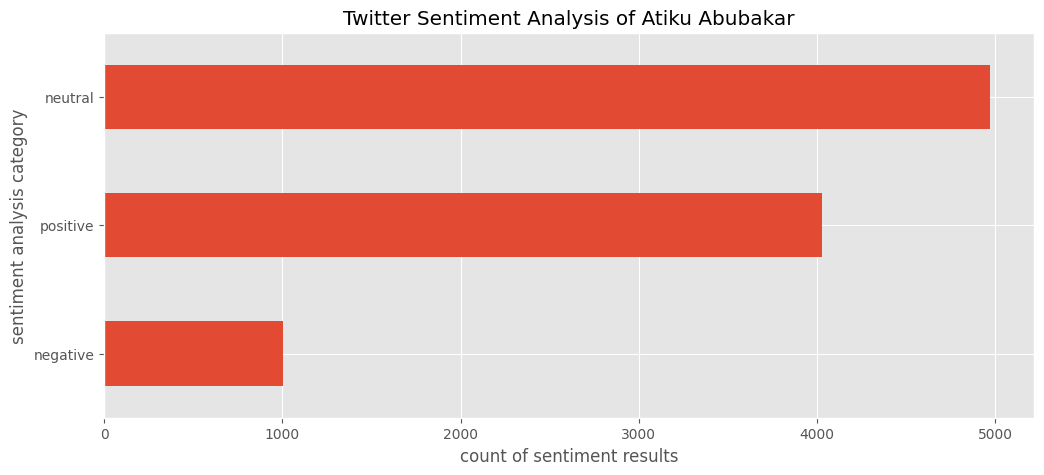

In [34]:
style.use('ggplot')
plt.figure(figsize=(12,5))
df.sentiment.value_counts().sort_values().plot(kind='barh')
plt.ylabel('sentiment analysis category')
plt.xlabel('count of sentiment results')
plt.title('Twitter Sentiment Analysis of Atiku Abubakar')
plt.show()

In [35]:
atiku_df = df[['tweet', 'sentiment', 'score', 'location', 'hashtags']]

In [36]:
atiku_df.head()

,tweet,sentiment,score,location,hashtags
0,@user @user @user @user @user @user in Ondo-S...,neutral,0.864072,"Maryland, USA",AtikuOkowa2023
1,,neutral,0.505880,Nigeria,AtikuOkowa2023 AtikuInOndo
2,Borno state PDP is doing well.. We will recove...,positive,0.886338,"Blue Earth, MN",RecoverNigeria
3,Borno state PDP is doing well.. We will recove...,positive,0.886338,NaN,RecoverNigeria
4,Atiku/Okowa is the only best Candidate we have...,positive,0.924370,NaN,AtikuOkowa2023 AtikuOrganizingForAction


In [37]:
atiku_df.to_csv('labelled_atiku.csv')

In [38]:
j = 1
sorted_df = df.sort_values(by=['score'])
for i in range(0, sorted_df.shape[0]):
    if sorted_df['sentiment'][i] == 'positive':
        print(str(j) + ') ' + sorted_df['tweet'][i])
        print()
        j = j + 1

1) Borno state PDP is doing well.. We will recover Borno come 2023.  with AtikuOkowa http

2) Borno state PDP is doing well.. We will recover Borno come 2023.  with AtikuOkowa http

3) Atiku/Okowa is the only best Candidate we have in Nigeria right now. My voter's card and my family's is for Atiku/Okowa insha Allah. Come 2023 vote Wisely. ONDO ATIKU IS COMING   http

4)  , the Sunshine State. Follow us on all our social media handles for updates. Come…Let’s  Together. http

5) The man behind the  is ATIKU ABUBAKAR. He never runs without a well-thought-out strategy in mind. He is always well-prepared.    http

6) Gov. Okowa is in Asaba making Delta State and Nigeria proud. @user is somewhere smiling telling his guys, "I told you he's a star boy" 😉 WE ARE PROUD OF OKOWA!    http

7) Ondo State welcomes the Unifier and the Presidential Campaign train for the  rally tomorrow November 30th 2022. It's the Sunshine State's time!!! As One We Can Get It Done.    http

8) @user Atikuokowa❤️🇭🇺. I

In [39]:
j = 1
sorted_df = df.sort_values(by=['score'])
for i in range(0, sorted_df.shape[0]):
    if sorted_df['sentiment'][i] == 'neutral':
        print(str(j) + ') ' + sorted_df['tweet'][i])
        print()
        j = j + 1

1) @user @user @user @user @user @user  in Ondo-State

2)  

3) 

4) His Excellency tomorrow live Ondo   http

5) @user @user @user @user Till today Jonathan hasn't done anything good for PDP as a party worth remembering. However, we have passed that stage now, we're starting again in 2023 so help us God Amen! 

6) @user Go and sit down with your baseless information. Come 2023 AtikuOkowa will rule this country.

7) Ondo State. Get ready to receive the  team tomorrow.    http

8) @user @user @user Opposition isn't madness. We give credible alternative and solutions That embodies .   

9)      http

10)  in Ondo tomorrow✔️✔️✔️ http

11) : As part of final preparations for the Presidential Campaign Rally Tomorrow, the @user National Publicity Secretary, Hon. @user the NOS and PCC Director of Field Operations, Hon Umar Bature, other leaders and stakeholders of the party in… http

12) @user  http

13)  http

14)   http

15) The Next Election Is About Choice And People Have Made This Bold S

In [40]:
j = 1
sorted_df = df.sort_values(by=['score'])
for i in range(0, sorted_df.shape[0]):
    if sorted_df['sentiment'][i] == 'negative':
        print(str(j) + ') ' + sorted_df['tweet'][i])
        print()
        j = j + 1

1) I AM SOMETHING AND I AM THE FATHER OF ALL LIARS. WHO AM I ? @user 🤣😂GOD FORBID WHAT A MAN CAN DO TO HIS DISTANT RELATIVE FOR STOMACH INFRASTRUCTURE.  OMOKRI IS A BIG DISAPPOINTMENT TO ENGLISH LANGUAGE😂🤣     http

2) @user @user This Dafty that is politically useless 

3) @user This is a political sponsored protest against okowa.. And it is no surprise that you all rally boy's are the ones amplifying the charade. Get use to  Administration.

4) @user @user @user @user @user @user @user @user @user @user No matter what they say about our Candidates, we'll still defeat them. .

5) @user Please where are all those paid minions, come and rant your mouths lets hear you. Delta State is Hosting the National sports Festival. Okowa finish work here.  

6) Dele Momodu, Sowore, ex-APC aspirants meet Tuesday http This is a big lie and just a fiction of the imagination of the writer. Let's stop this politics of balabu and blu blu and focus on the task ahead to  with 

7) @user Now you guys have s